In [1]:
import os 
import logging 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm 
from alibi_detect.models.tensorflow import elbo 
from alibi_detect.od import OutlierVAE 
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.saving import save_detector, load_detector 
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
load_outlier_detector = True

filepath = './alibi_vae_cifar10'
detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierVAE'
filepath = os.path.join(filepath, detector_name)

if load_outlier_detector:
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:
    latent_dim = 1024
    
    encoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(32, 32, 3)),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
    ])
    decoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(latent_dim, )),
        Dense(4 * 4 * 128),
        Reshape(target_shape=(4, 4, 128)),
        Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
    ])
    
    od = OutlierVAE(
        threshold=0.015,
        score_type='mse',
        encoder_net=encoder_net,
        decoder_net=decoder_net,
        latent_dim=latent_dim,
        samples=2
    )
    
    od.fit(
        X_train,
        loss_fn=elbo,
        cov_elbo=dict(sim=.05),
        epochs=50,
        verbose=False
    )
    
    save_detector(od, filepath)

C:\Users\86183\anaconda23-3\lib\site-packages\alibi_detect\saving\_tensorflow\loading.py:224: UserWarning: Trying to load detector from an older version.This may lead to breaking code or invalid results.
  warnings.warn('Trying to load detector from an older version.'


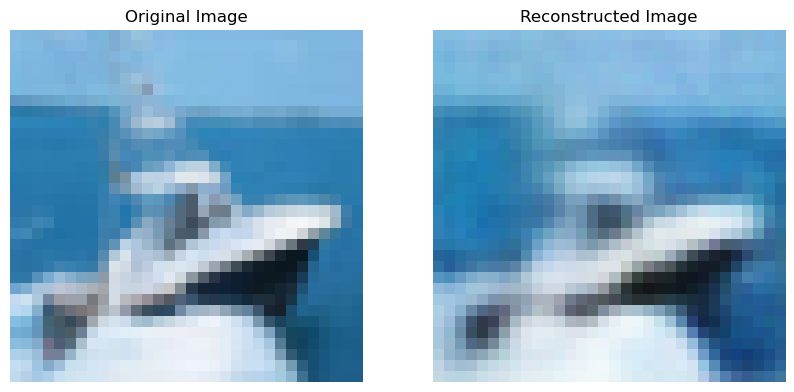

In [4]:
idx = 8 
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.title('Reconstructed Image')
plt.show()

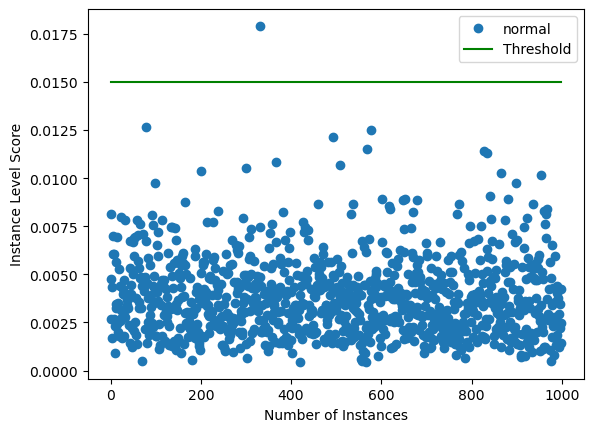

In [5]:
X = X_train[:1000]

od_preds = od.predict(
    X, 
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(X.shape[0], ).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

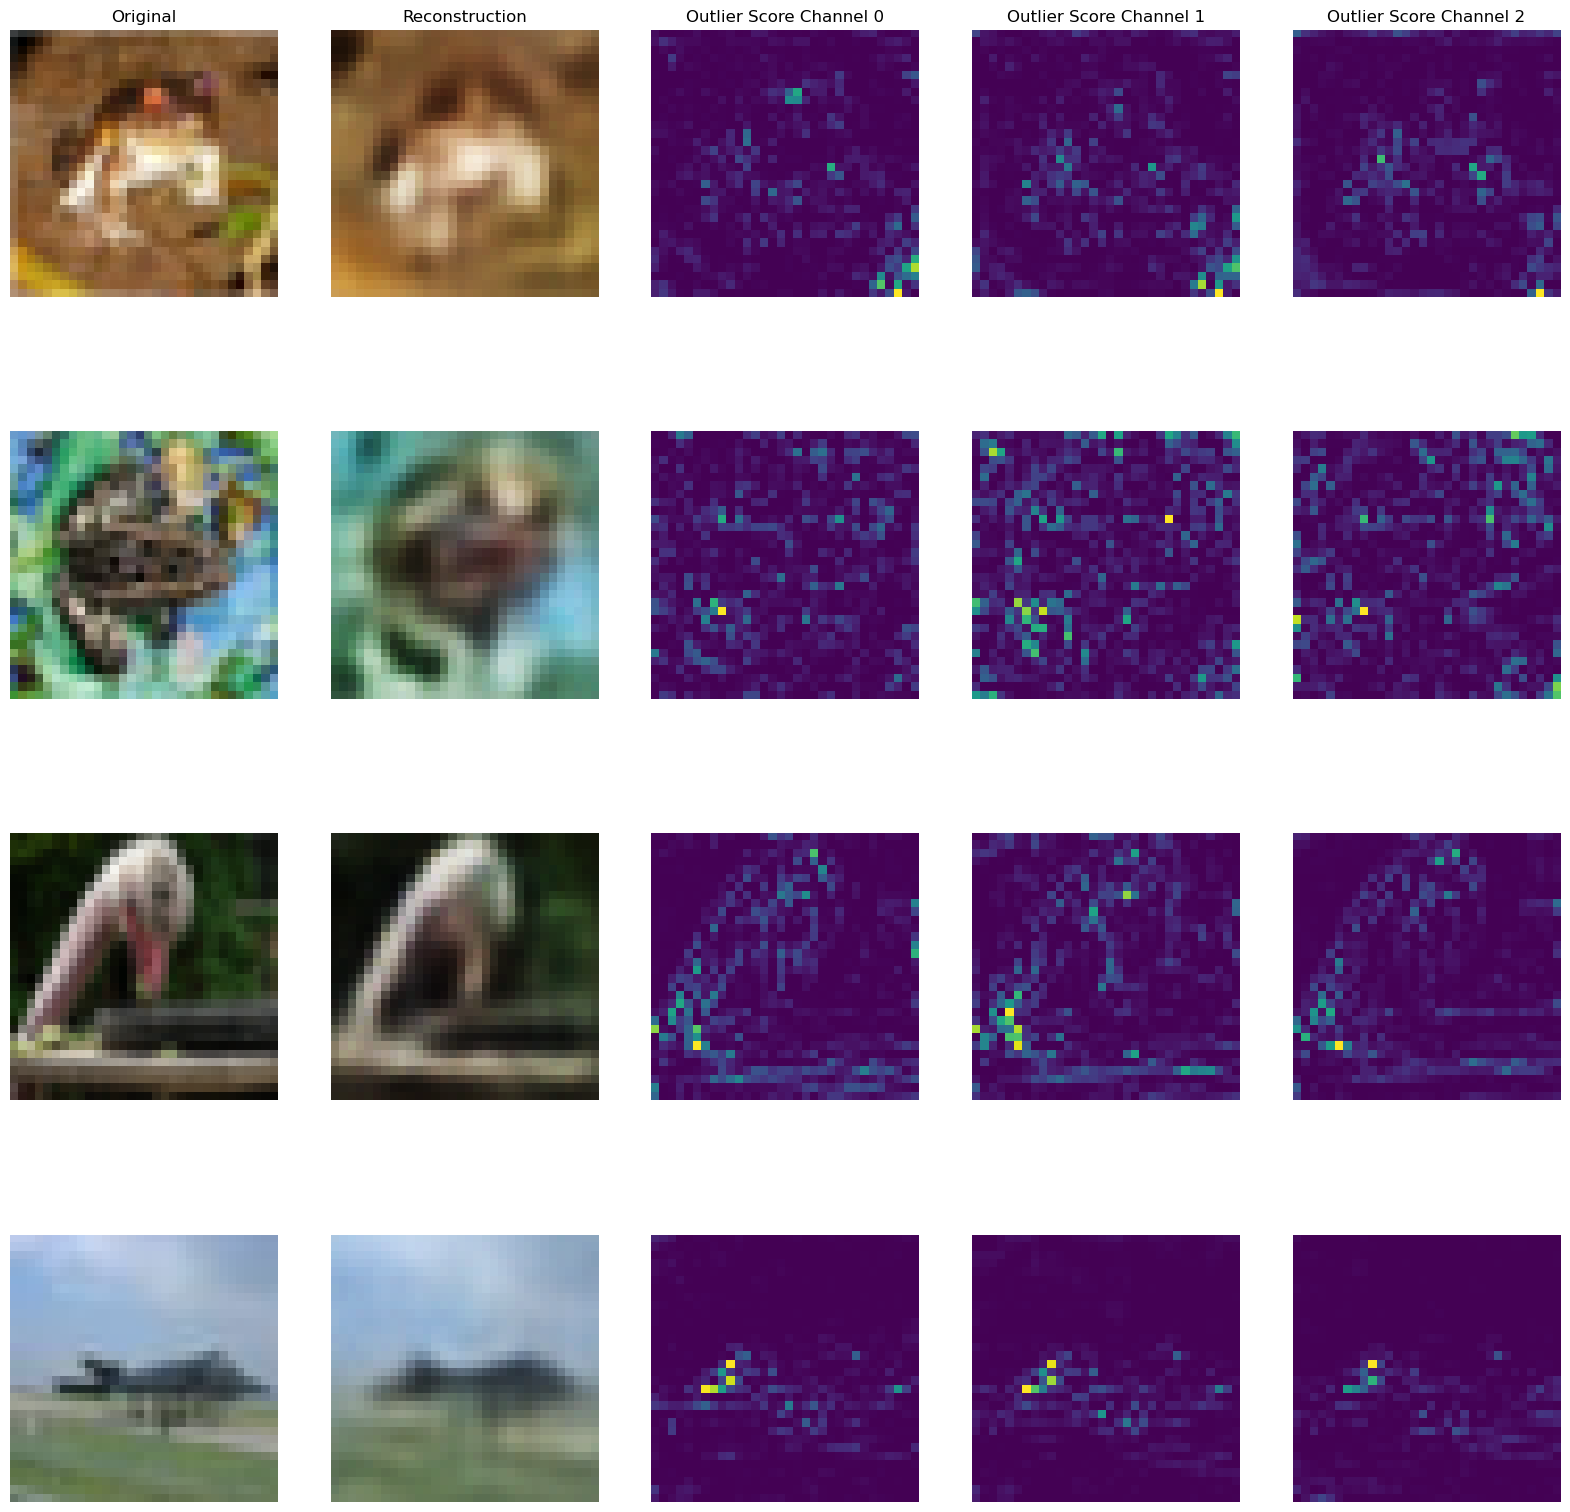

In [6]:
X_recon = od.vae(X).numpy()

plot_feature_outlier_image(
    od_preds,
    X,
    X_recon=X_recon,
    instance_ids=[0, 200, 400, 600],
    max_instances=5,
    outliers_only=False
)

In [7]:
n_mask_sizes = 10
n_masks = 20
n_imgs = 50 

mask_sizes = [(2 * n, 2 * n) for n in range(1, n_mask_sizes + 1)]
print(mask_sizes)
img_ids = np.arange(n_imgs)
X_orig = X[img_ids].reshape(img_ids.shape[0], 32, 32, 3)
print(X_orig.shape)

[(2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14), (16, 16), (18, 18), (20, 20)]
(50, 32, 32, 3)


In [8]:
all_img_scores = []
for i in tqdm(range(X_orig.shape[0])):
    img_scores = np.zeros((len(mask_sizes), ))
    for j, mask_size in enumerate(mask_sizes):
        X_mask, mask = apply_mask(
            X_orig[i].reshape(1, 32, 32, 3),
            mask_size=mask_size,
            n_masks=n_masks,
            channels=[0, 1, 2],
            mask_type='normal',
            noise_distr=(0, 1),
            clip_rng=(0, 1)
        )
        od_preds_mask = od.predict(X_mask)
        score = od_preds_mask['data']['instance_score']
        img_scores[j] = np.mean(score)
    all_img_scores.append(img_scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


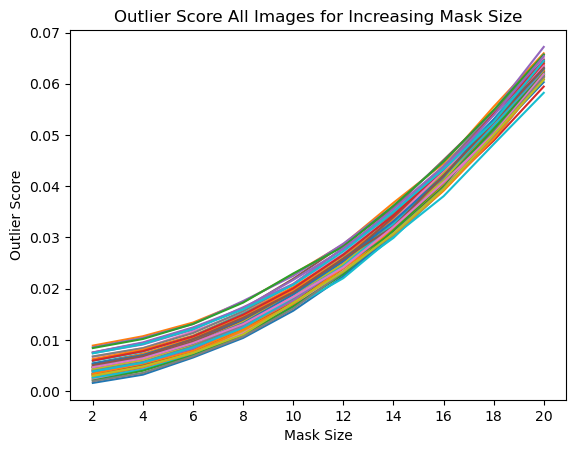

In [9]:
x_plt = [mask[0] for mask in mask_sizes]

for ais in all_img_scores:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
    
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.show()

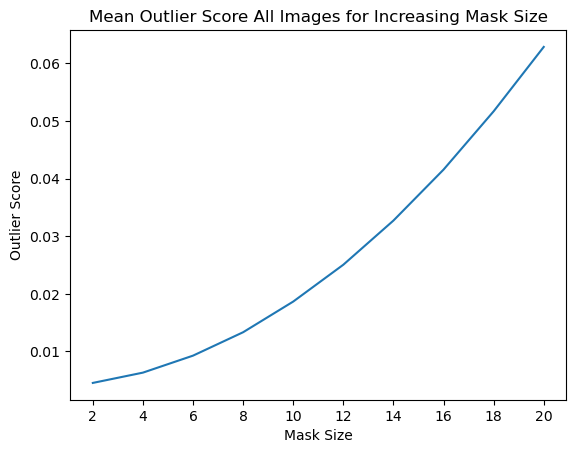

In [10]:
ais_np = np.zeros((len(all_img_scores), all_img_scores[0].shape[0]))
for i, ais in enumerate(all_img_scores):
    ais_np[i, :] = ais
ais_mean = np.mean(ais_np, axis=0)
plt.title('Mean Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.plot(x_plt, ais_mean)
plt.xticks(x_plt)
plt.show()

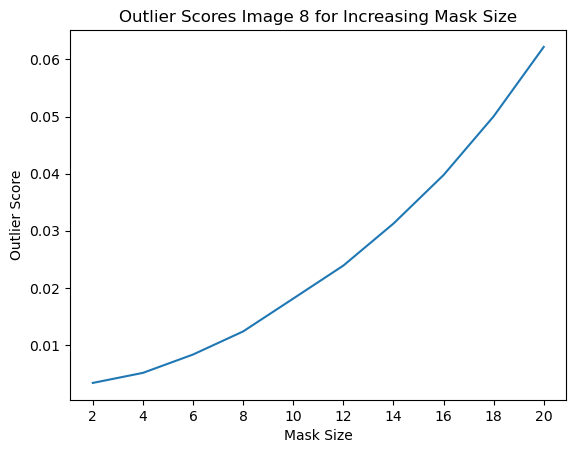

In [11]:
i = 8
plt.plot(x_plt, all_img_scores[i])
plt.xticks(x_plt)
plt.title('Outlier Scores Image {} for Increasing Mask Size'.format(i))
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.show()

In [12]:
all_X_mask = []
X_i = X_orig[i].reshape(1, 32, 32, 3)
all_X_mask.append(X_i)

for j, mask_size in enumerate(mask_sizes):
    X_mask, mask = apply_mask(
        X_i, 
        mask_size=mask_size,
        n_masks=1,
        channels=[0, 1, 2],
        mask_type='normal',
        noise_distr=(0, 1),
        clip_rng=(0, 1)
    )
    all_X_mask.append(X_mask)
all_X_mask = np.concatenate(all_X_mask, axis=0)
all_X_recon = od.vae(all_X_mask).numpy()
od_preds = od.predict(all_X_mask)

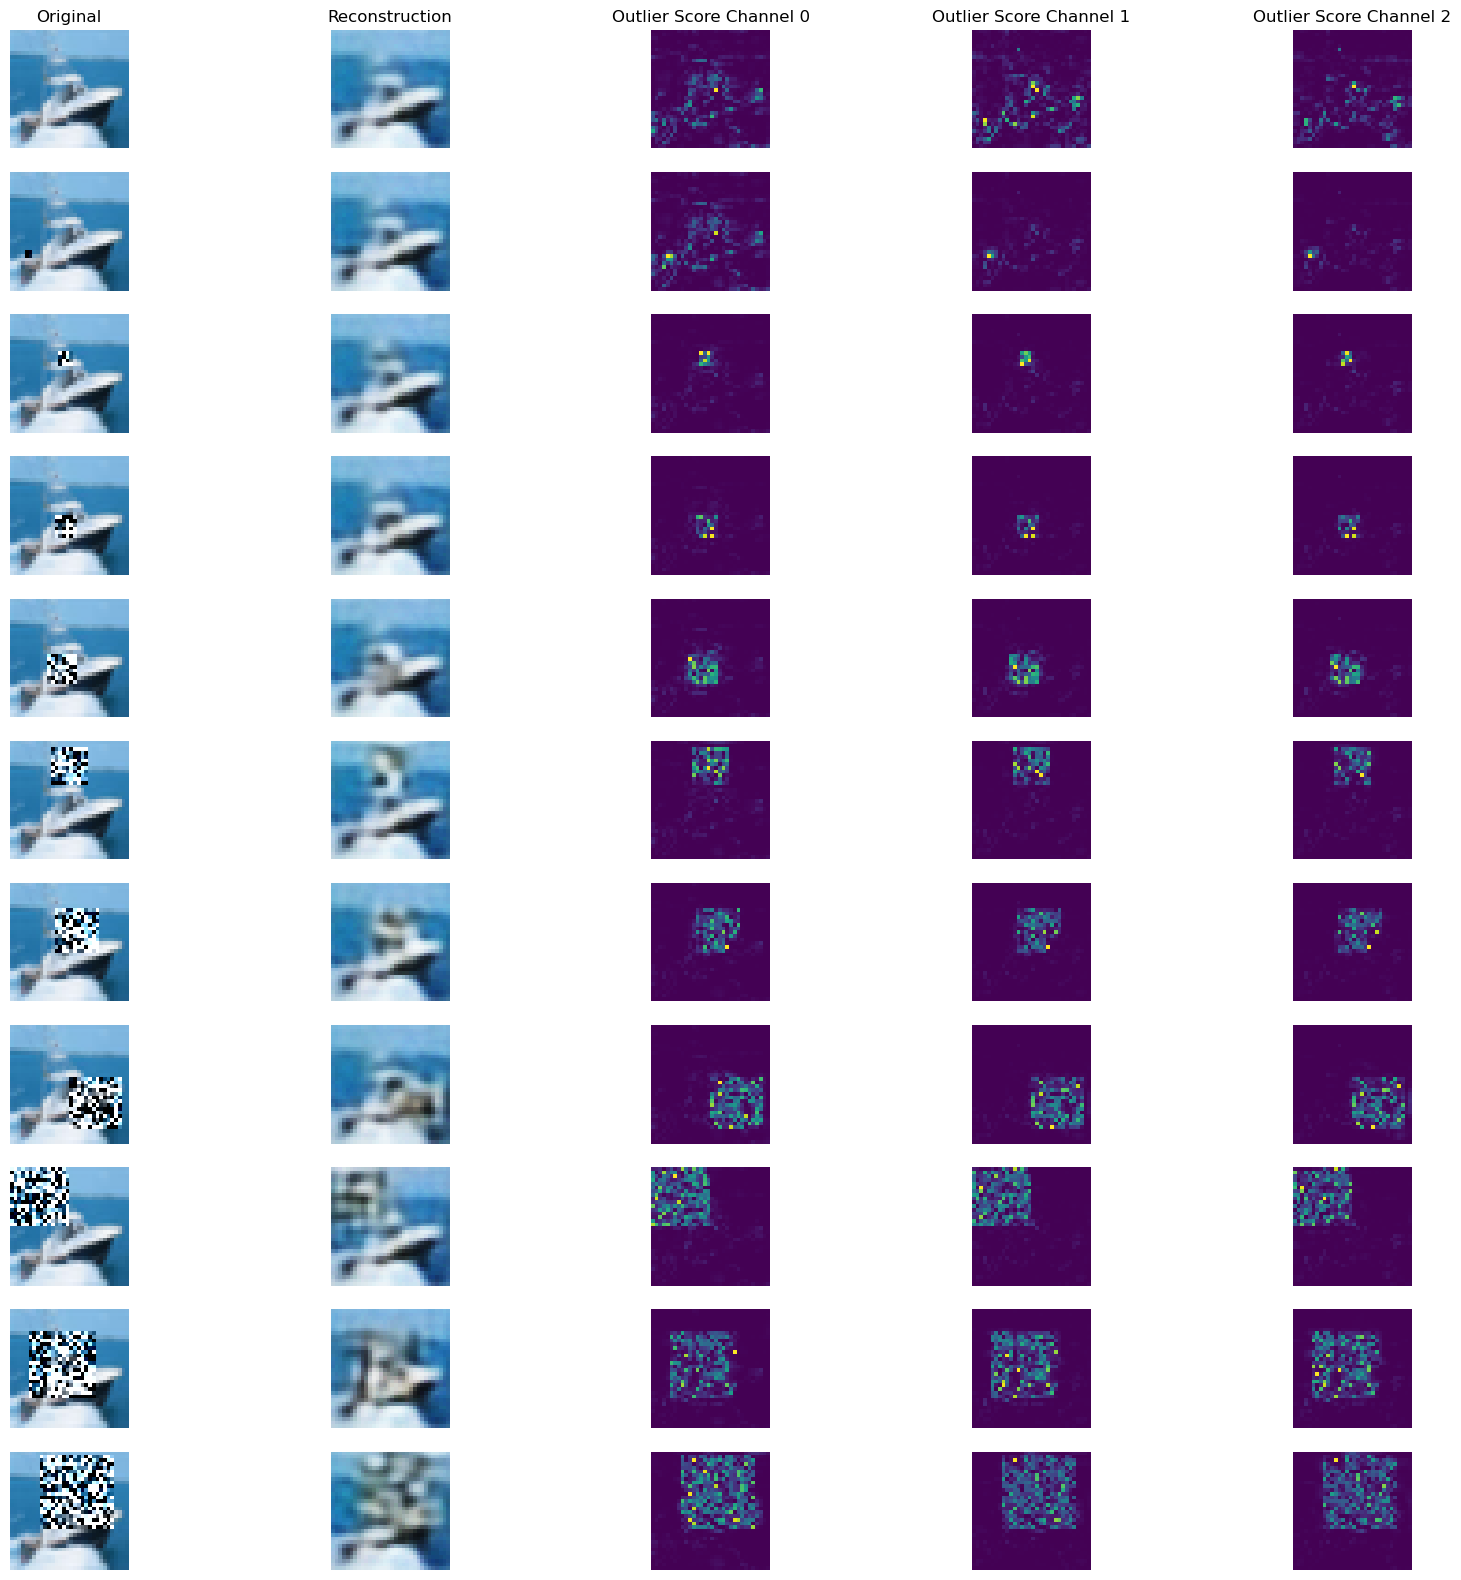

In [13]:
plot_feature_outlier_image(
    od_preds,
    all_X_mask,
    X_recon=all_X_recon,
    max_instances=all_X_mask.shape[0],
    n_channels=3
)

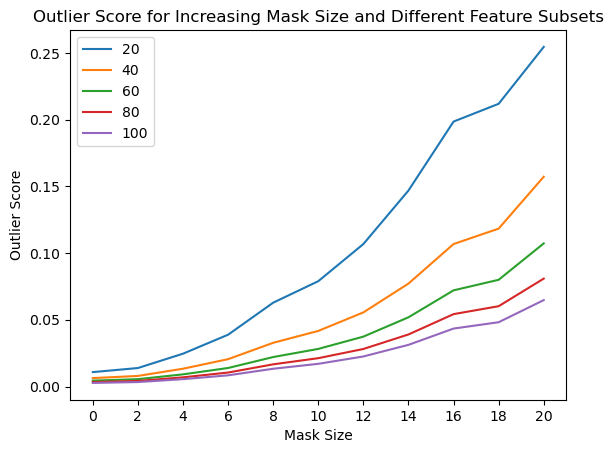

In [14]:
perc_list = [20, 40, 60, 80, 100]

all_perc_scores = []
for perc in perc_list:
    od_pred_perc = od.predict(all_X_mask, outlier_perc=perc)
    iscore = od_pred_perc['data']['instance_score']
    all_perc_scores.append(iscore)
    
x_plt = [0] + x_plt 
for aps in all_perc_scores:
    plt.plot(x_plt, aps)
    plt.xticks(x_plt)
plt.legend(perc_list)
plt.title('Outlier Score for Increasing Mask Size and Different Feature Subsets')
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.show()

In [15]:
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(X, threshold_perc=99)
print('New threshold: {}'.format(od.threshold))

Current threshold: 0.015
New threshold: 0.01038321428000927
